In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import argparse
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
print('\n'.join([''.join([('Data_Science_is_my_Passion_'[(x-y) % len('Data_Science_is_my_Passion_')]
                           if ((x*0.05)**2+(y*0.1)**2-1)**3-(x*0.05)**2*(y*0.1)**3 <= 0 else ' ')
                          for x in range(-30, 30)]) for y in range(15, -15, -1)]))

                                                            
                                                            
                                                            
                ata_Scien           ssion_Dat               
            n_Data_Science_is   _Passion_Data_Sci           
          on_Data_Science_is_my_Passion_Data_Scienc         
         on_Data_Science_is_my_Passion_Data_Science_        
        on_Data_Science_is_my_Passion_Data_Science_is       
        n_Data_Science_is_my_Passion_Data_Science_is_       
        _Data_Science_is_my_Passion_Data_Science_is_m       
        Data_Science_is_my_Passion_Data_Science_is_my       
        ata_Science_is_my_Passion_Data_Science_is_my_       
        ta_Science_is_my_Passion_Data_Science_is_my_P       
         _Science_is_my_Passion_Data_Science_is_my_P        
          cience_is_my_Passion_Data_Science_is_my_P         
          ience_is_my_Passion_Data_Science_is_my_Pa         
            ce_is_my_Pas

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def get_namespace():
    parser = argparse.ArgumentParser()
    parser.add_argument('--debug', dest='debug', action='store_true')
    parser.add_argument('--no-debug', dest='debug', action='store_false')
    parser.set_defaults(debug=True)
    return parser.parse_args()
    
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

**Application Train**

In [4]:
def application_train():

    df = pd.read_csv('application_train.csv')
    test_df = pd.read_csv('application_test.csv')

    df = df.append(test_df).reset_index()
    df = df[df['CODE_GENDER'] != 'XNA']

    lbe = LabelEncoder()

    for col in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
            df[col] = lbe.fit_transform(df[col])

    df = pd.get_dummies(df, dummy_na = True)

    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    df.drop("index", axis = 1, inplace =  True)

    df.columns = pd.Index(["APP_" + col for col in df.columns.tolist()])

    df.rename(columns={"APP_SK_ID_CURR":"SK_ID_CURR"}, inplace = True)

    df.rename(columns={"APP_TARGET":"TARGET"}, inplace = True)
    
    return df

**Bureau and Bureau Balance**

In [5]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
       
    bureau = pd.read_csv('bureau.csv')
    bb = pd.read_csv('bureau_balance.csv')
    
    bureau.drop(['CREDIT_CURRENCY'], axis = 1, inplace =True)
    
    bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].replace([
              'Microloan',
              'Loan for business development', 
              'Another type of loan',
              'Unknown type of loan', 
              'Loan for working capital replenishment',
              "Loan for purchase of shares (margin lending)",                                                
              'Cash loan (non-earmarked)', 
              'Real estate loan',
              "Loan for the purchase of equipment", 
              "Interbank credit", 
              "Mobile operator loan"], 'Rare')
    
    bureau.loc[bureau['DAYS_CREDIT_ENDDATE'] < -20000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    bureau.loc[bureau['DAYS_ENDDATE_FACT'] < -20000, 'DAYS_ENDDATE_FACT'] = np.nan
    bureau.loc[bureau['DAYS_CREDIT_UPDATE'] < -20000, 'DAYS_CREDIT_UPDATE'] = np.nan
    
    bureau['NEW_DAYS_CREDIT_UPDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_UPDATE'] 
    bureau['NEW_EARLY_PAID'] = (bureau['DAYS_ENDDATE_FACT'] <= bureau['DAYS_CREDIT_ENDDATE']).astype('float') 
    bureau['NEW_OVERDUE_TO_CREDIT_SUM_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM']
    bureau['NEW_OVERDUE_TO_DEBT_SUM_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['NEW_DEBT_SUM_TO_CREDIT_SUM_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
    bureau['NEW_ANNUITY_TO_CREDIT_SUM_RATIO'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']
    bureau['NEW_AMT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT']/(1+bureau['AMT_CREDIT_SUM'])
    
    def one_hot_encoder(df, nan_as_category):
        original_columns = list(df.columns)
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
        df = pd.get_dummies(df, columns=categorical_columns,dummy_na=nan_as_category)
        new_columns = [c for c in df.columns if c not in original_columns]
        return df, new_columns
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category = True)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = True)
    
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat: bb_aggregations[col] = ['mean']
        
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'NEW_OVERDUE_TO_CREDIT_SUM_RATIO': ['min', 'max', 'mean'], 
        'NEW_OVERDUE_TO_DEBT_SUM_RATIO': ['min', 'max', 'mean'],
        'NEW_DEBT_SUM_TO_CREDIT_SUM_RATIO': ['min', 'max', 'mean'], 
        'NEW_ANNUITY_TO_CREDIT_SUM_RATIO': ['min', 'max', 'mean'],
        'NEW_DAYS_CREDIT_UPDATE_DIFF': ['min', 'max', 'mean'],
        'NEW_AMT_LIMIT_RATIO': ['min', 'max', 'mean'],
        'NEW_EARLY_PAID': ['mean']}

    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean', 'sum']
        
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    del bureau, bb
    return bureau_agg

**Installments Payments**

In [6]:
def installments_payments():

    ins = pd.read_csv('installments_payments.csv')

    ins['NEW_DAYS_PAID_EARLIER'] = ins['DAYS_INSTALMENT']-ins['DAYS_ENTRY_PAYMENT']

    ins['NEW_NUM_PAID_LATER'] = ins['NEW_DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)

    agg_list = {'NUM_INSTALMENT_VERSION':['nunique'],
               'NUM_INSTALMENT_NUMBER':'max',
               'DAYS_INSTALMENT':['min','max'],
               'DAYS_ENTRY_PAYMENT':['min','max'],
               'AMT_INSTALMENT':['min','max','sum','mean'],
               'AMT_PAYMENT':['min','max','sum','mean'],
               'NEW_DAYS_PAID_EARLIER':'mean',
               'NEW_NUM_PAID_LATER':'sum'}

    ins_agg = ins.groupby('SK_ID_PREV').agg(agg_list)

    ins_agg.columns = pd.Index(["INS_" + e[0] + '_' + e[1].upper() for e in ins_agg.columns.tolist()])

    ins_agg.drop(['INS_DAYS_INSTALMENT_MIN',
                   'INS_DAYS_INSTALMENT_MAX',
                   'INS_DAYS_ENTRY_PAYMENT_MIN',
                   'INS_DAYS_ENTRY_PAYMENT_MAX'],axis=1,inplace=True)

    ins_agg['INS_NEW_PAYMENT_PERC'] = ins_agg['INS_AMT_PAYMENT_SUM'] / ins_agg['INS_AMT_INSTALMENT_SUM']
    ins_agg['INS_NEW_PAYMENT_DIFF'] = ins_agg['INS_AMT_INSTALMENT_SUM'] - ins_agg['INS_AMT_PAYMENT_SUM']
    
    agg_list_previous_application = {}
    
    for col in ins_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]
    
    ins_agg.reset_index(inplace = True) 
    
    return agg_list_previous_application, ins_agg

**Posh Cash Balance**

In [7]:
def pos_cash_balance(agg_list_previous_application):
    pos = pd.read_csv('POS_CASH_balance.csv')
    pos = pd.get_dummies(pos, columns=['NAME_CONTRACT_STATUS'], dummy_na = True)
        agg_list = {'MONTHS_BALANCE':['min','max'],
                                            'CNT_INSTALMENT':['min','max'],
                                            'CNT_INSTALMENT_FUTURE':['min','max'],
                                            'SK_DPD':['max','mean'],
                                            'SK_DPD_DEF':['max','mean'],
                                            'NAME_CONTRACT_STATUS_Active':'sum',
                                            'NAME_CONTRACT_STATUS_Amortized debt':'sum',
                                            'NAME_CONTRACT_STATUS_Approved':'sum',
                                            'NAME_CONTRACT_STATUS_Canceled':'sum',
                                            'NAME_CONTRACT_STATUS_Completed':'sum',
                                            'NAME_CONTRACT_STATUS_Demand':'sum',
                                            'NAME_CONTRACT_STATUS_Returned to the store':'sum',
                                            'NAME_CONTRACT_STATUS_Signed':'sum',
                                            'NAME_CONTRACT_STATUS_XNA':'sum',
                                            'NAME_CONTRACT_STATUS_nan':'sum'
                                          }

    pos_agg = pos.groupby('SK_ID_PREV').agg(agg_list)
    pos_agg.columns= pd.Index(["POS_" + e[0] + '_' + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']= (pos_agg['POS_CNT_INSTALMENT_FUTURE_MIN']==0) & (pos_agg['POS_NAME_CONTRACT_STATUS_Completed_SUM']==0)
    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']=pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME'].astype(int)
    pos_agg.drop(['POS_NAME_CONTRACT_STATUS_Approved_SUM',
                   'POS_NAME_CONTRACT_STATUS_Amortized debt_SUM',
                   'POS_NAME_CONTRACT_STATUS_Canceled_SUM',
                   'POS_NAME_CONTRACT_STATUS_Returned to the store_SUM',
                   'POS_NAME_CONTRACT_STATUS_Signed_SUM',
                   'POS_NAME_CONTRACT_STATUS_XNA_SUM',
                   'POS_NAME_CONTRACT_STATUS_nan_SUM'],axis=1,inplace=True)
    for col in pos_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]

    pos_agg.reset_index(inplace = True)     
    
    return agg_list_previous_application, pos_agg

**Credit Card Balance**

In [8]:
def credit_card_balance():

    CCB = pd.read_csv('credit_card_balance.csv')

    CCB = pd.get_dummies(CCB, columns= ['NAME_CONTRACT_STATUS'] ) 

    dropthis = ['NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Demand',
           'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
           'NAME_CONTRACT_STATUS_Signed' ]

    CCB = CCB.drop(dropthis, axis=1)

    grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NUMBER_OF_LOANS_PER_CUSTOMER'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NUMBER_OF_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NUMBER_OF_INSTALMENTS': 'TOTAL_INSTALMENTS_OF_ALL_LOANS'})
    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')

    CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS_OF_ALL_LOANS']/CCB['NUMBER_OF_LOANS_PER_CUSTOMER']).astype('uint32')

    def delayed_days(DPD):

        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1  
        return c 

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: delayed_days(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NUMBER_OF_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_DPD'].mean().reset_index().rename(index = str, columns = {'NUMBER_OF_DPD' : 'DPD_COUNT'})

    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')


    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)        
        c = 0 
       
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MIN_MISSED_PAYMENTS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100  
    del CCB['DRAWINGS_ATM']
    del CCB['DRAWINGS_TOTAL']

    grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NUMBER_OF_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')


    CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NUMBER_OF_DRAWINGS'])*100     
    del CCB['TOTAL_DRAWINGS']
    del CCB['NUMBER_OF_DRAWINGS']

    grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    del CCB['DRAWINGS_RATIO1']

    CCB['CC_COUNT'] = CCB.groupby('SK_ID_CURR').size()

    CCB_agg = CCB.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE':["sum","mean"], 
        'AMT_BALANCE':["sum","mean","min","max"],
        'AMT_CREDIT_LIMIT_ACTUAL':["sum","mean"], 

        'AMT_DRAWINGS_ATM_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_CURRENT':["sum","mean","min","max"], 
        'AMT_DRAWINGS_OTHER_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_POS_CURRENT':["sum","mean","min","max"], 
        'AMT_INST_MIN_REGULARITY':["sum","mean","min","max"],
        'AMT_PAYMENT_CURRENT':["sum","mean","min","max"], 
        'AMT_PAYMENT_TOTAL_CURRENT':["sum","mean","min","max"],
        'AMT_RECEIVABLE_PRINCIPAL':["sum","mean","min","max"], 
        'AMT_RECIVABLE':["sum","mean","min","max"], 
        'AMT_TOTAL_RECEIVABLE':["sum","mean","min","max"],

        'CNT_DRAWINGS_ATM_CURRENT':["sum","mean"], 
        'CNT_DRAWINGS_CURRENT':["sum","mean","max"],
        'CNT_DRAWINGS_OTHER_CURRENT':["mean","max"], 
        'CNT_DRAWINGS_POS_CURRENT':["sum","mean","max"],
        'CNT_INSTALMENT_MATURE_CUM':["sum","mean","max","min"],    
        'SK_DPD':["sum","mean","max"], 
        'SK_DPD_DEF':["sum","mean","max"],

        'NAME_CONTRACT_STATUS_Active':["sum","mean","min","max"], 
        'INSTALLMENTS_PER_LOAN':["sum","mean","min","max"],

        'NUMBER_OF_LOANS_PER_CUSTOMER':["mean"], 
        'DPD_COUNT':["mean"],
        'PERCENTAGE_MIN_MISSED_PAYMENTS':["mean"], 
        'CASH_CARD_RATIO':["mean"], 
        'DRAWINGS_RATIO':["mean"]})

    CCB_agg.columns = pd.Index(['CCB_' + e[0] + "_" + e[1].upper() for e in CCB_agg.columns.tolist()])

    CCB_agg.reset_index(inplace = True)
    
    return CCB_agg

**Previous Applications**

In [9]:
def previous_application(agg_list_previous_application):


    df_prev = pd.read_csv('previous_application.csv')

    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY')
    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')

    a = [8,9,10,11,12,13,14,15,16,17]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(a, 'working_hours')

    b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(b, 'off_hours')


    df_prev["DAYS_DECISION"] = [1 if abs(i/(12*30)) <=1 else 0 for i in df_prev.DAYS_DECISION]

    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace('Unaccompanied', 'alone')

    b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people']
    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace(b, 'not_alone')

    a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
         'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
         'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'] 
    df_prev["NAME_GOODS_CATEGORY"] = df_prev["NAME_GOODS_CATEGORY"].replace(a, 'others')

    a = ['Auto technology', 'Jewelry', 'MLM partners', 'Tourism'] 
    df_prev["NAME_SELLER_INDUSTRY"] = df_prev["NAME_SELLER_INDUSTRY"].replace(a, 'others')
   
    df_prev["LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    df_prev["NEW_LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    
    k = df_prev.DAYS_LAST_DUE_1ST_VERSION - df_prev.DAYS_LAST_DUE
    df_prev["NEW_CHURN_PREV"] = [1 if i >= 0 else (0 if i < 0  else "NaN") for i in k]

    df_prev[(df_prev['AMT_CREDIT'] == 0) | (df_prev['AMT_GOODS_PRICE'] == 0)]['NEW_INSURANCE'] = np.nan
    df_prev['sigorta_miktari'] = df_prev['AMT_CREDIT'] - df_prev['AMT_GOODS_PRICE']
    df_prev["NEW_INSURANCE"] = df_prev['sigorta_miktari'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else np.nan))
    df_prev.drop('sigorta_miktari', axis=1, inplace=True)

   
    drop_list = ['AMT_DOWN_PAYMENT', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
                'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE','DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']
    df_prev.drop(drop_list, axis = 1, inplace = True)

    category_columns=[]
    for i in df_prev.columns:
        if df_prev[i].dtypes == "O":
            category_columns.append(i)

    df_prev = pd.get_dummies(df_prev, columns = category_columns )

    prev_agg_list = {"SK_ID_CURR":["count"], 
                "AMT_ANNUITY":["max"],
                "AMT_APPLICATION":["min","mean","max"],
                "AMT_CREDIT":["max"], 
                "AMT_GOODS_PRICE":["sum", "mean"],
                "NFLAG_LAST_APPL_IN_DAY":["sum","mean"], 
                "RATE_DOWN_PAYMENT":["sum", "mean"],
                "RATE_INTEREST_PRIMARY":["sum", "mean"],
                "RATE_INTEREST_PRIVILEGED":["sum", "mean"],
                "DAYS_DECISION":["sum"],
                "NEW_LOAN_RATE":["sum", "mean", "min", "max"],
                "NEW_INSURANCE":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Cash loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Consumer loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Revolving loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_XNA":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEKEND":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEK_DAY":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_off_hours":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_working_hours":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_N":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_Y":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Building a house or an annex":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Business development":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a garage":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a home":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a new car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a used car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Car repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Education":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Everyday expenses":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Furniture":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Gasification / water supply":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Hobby":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Journey":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Medicine":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Money for a third person":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Other":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Payments on other loans":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Refusal to name the goal":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Urgent needs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XAP":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XNA":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Approved":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Canceled":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Refused":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Unused offer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cash through the bank":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cashless from the account of the employer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Non-cash from your account":["sum", "mean"],
                "NAME_PAYMENT_TYPE_XNA":["sum", "mean"],
                "CODE_REJECT_REASON_CLIENT":["sum", "mean"],
                "CODE_REJECT_REASON_HC":["sum", "mean"],
                "CODE_REJECT_REASON_LIMIT":["sum", "mean"],
                "CODE_REJECT_REASON_SCO":["sum", "mean"],
                "CODE_REJECT_REASON_SCOFR":["sum", "mean"],
                "CODE_REJECT_REASON_SYSTEM":["sum", "mean"],
                "CODE_REJECT_REASON_VERIF":["sum", "mean"],
                "CODE_REJECT_REASON_XAP":["sum", "mean"],
                "CODE_REJECT_REASON_XNA":["sum", "mean"],
                "NAME_TYPE_SUITE_alone":["sum", "mean"],
                "NAME_TYPE_SUITE_not_alone":["sum", "mean"],
                "NAME_CLIENT_TYPE_New":["sum", "mean"],
                "NAME_CLIENT_TYPE_Refreshed":["sum", "mean"],
                "NAME_CLIENT_TYPE_Repeater":["sum", "mean"],
                "NAME_CLIENT_TYPE_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Audio/Video":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Clothing and Accessories":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Computers":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Construction Materials":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Consumer Electronics":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Furniture":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Mobile":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Photo / Cinema Equipment":["sum", "mean"],
                "NAME_GOODS_CATEGORY_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_others":["sum", "mean"],
                "NAME_PORTFOLIO_Cards":["sum", "mean"],
                "NAME_PORTFOLIO_Cars":["sum", "mean"],
                "NAME_PORTFOLIO_Cash":["sum", "mean"],
                "NAME_PORTFOLIO_POS":["sum", "mean"],
                "NAME_PORTFOLIO_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_walk-in":["sum", "mean"],
                "NAME_PRODUCT_TYPE_x-sell":["sum", "mean"],
                "CHANNEL_TYPE_AP+ (Cash loan)":["sum", "mean"],
                "CHANNEL_TYPE_Car dealer":["sum", "mean"],
                "CHANNEL_TYPE_Channel of corporate sales":["sum", "mean"],
                "CHANNEL_TYPE_Contact center":["sum", "mean"],
                "CHANNEL_TYPE_Country-wide":["sum", "mean"],
                "CHANNEL_TYPE_Credit and cash offices":["sum", "mean"],
                "CHANNEL_TYPE_Regional / Local":["sum", "mean"],
                "CHANNEL_TYPE_Stone":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Clothing":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Connectivity":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Construction":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Consumer electronics":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Furniture":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Industry":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_XNA":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_others":["sum", "mean"],
                "NAME_YIELD_GROUP_XNA":["sum", "mean"],
                "NAME_YIELD_GROUP_high":["sum", "mean"],
                "NAME_YIELD_GROUP_low_action":["sum", "mean"],
                "NAME_YIELD_GROUP_low_normal":["sum", "mean"],
                "NAME_YIELD_GROUP_middle":["sum", "mean"],
                "NEW_CHURN_PREV_0":["sum", "mean"],
                "NEW_CHURN_PREV_1":["sum", "mean"],
                "NEW_CHURN_PREV_NaN":["sum", "mean"]}

    prev_agg_list.update(agg_list_previous_application)
        
    return prev_agg_list, df_prev

**Combining all data**

In [10]:
def pre_processing_and_combine():

    
    with timer("Process application train"):
        df = application_train()
        print("application train & test shape:", df.shape)
        
    
    with timer("Bureau and Bureau Balance"):
        bureau_and_bb_agg = bureau_and_balance()
        print("Bureau and Bureau Balance:", bureau_and_bb_agg.shape)
        
    with timer("Installment Payments"):
        agg_list_previous_application, ins_agg = installments_payments()
        print("Installment Payments:", ins_agg.shape)    
    
    with timer("Pos Cash Balance"):
        agg_list_previous_application, pos_agg = pos_cash_balance(agg_list_previous_application)
        print("Pos Cash Balance:", pos_agg.shape)  
        
    
    with timer("Credit Card Balance"):
        CCB_agg = credit_card_balance()
        print("Credit Card Balance:", CCB_agg.shape) 
    
    with timer("previous_application"):
        prev_agg_list, df_prev = previous_application(agg_list_previous_application)
        print("previous_application:", df_prev.shape) 
        
        
    with timer("All tables are combining"):
        df_prev_ins = df_prev.merge(ins_agg, how = 'left', on = 'SK_ID_PREV')
        df_prev_ins_pos = df_prev_ins.merge(pos_agg, how = 'left', on = 'SK_ID_PREV')
        df_prev_ins_pos_agg = df_prev_ins_pos.groupby("SK_ID_CURR").agg(prev_agg_list).reset_index()
        df_prev_ins_pos_agg.columns = pd.Index(["PREV_" + col[0] + "_" + col[1].upper() for col in df_prev_ins_pos_agg.columns.tolist()])
        df_prev_ins_pos_agg.rename(columns={"PREV_SK_ID_CURR_":"SK_ID_CURR"}, inplace = True)
     
        df_prev_others = df.merge(df_prev_ins_pos_agg, how = 'left',on = 'SK_ID_CURR')
    
   
        df_prev_ins_pos_ccb = df_prev_others.merge(CCB_agg, how = 'left',on = 'SK_ID_CURR')
    
   
        all_data = df_prev_ins_pos_ccb.merge(bureau_and_bb_agg, how = 'left',on = 'SK_ID_CURR')
        
        print("all_data process:", all_data.shape) 

    return all_data

**Model Development**

In [11]:
def modeling(all_data):

    train_df = all_data[all_data['TARGET'].notnull()]
    test_df = all_data[all_data['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    folds = KFold(n_splits = 10, shuffle = True, random_state = 1001) 

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]

        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
                n_jobs = -1,
                n_estimators=10000,
                learning_rate=0.02,
                num_leaves=34,
                colsample_bytree=0.9497036,
                subsample=0.8715623,
                max_depth=8,
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                silent=-1,
                verbose=-1, )


        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

      
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))) 


    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds)) 

    
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv('kaggle_submission_new', index=False)

    display_importances(feature_importance_df)

    return feature_importance_df

**Main**

In [12]:
def main():
    
    with timer("Preprocessing Time"):
        all_data = pre_processing_and_combine()
    
    with timer("Modeling"):
        feat_importance = modeling(all_data)

application train & test shape: (356251, 260)
Process application train - done in 6s
Bureau and Bureau Balance: (305811, 67)
Bureau and Bureau Balance - done in 21s
Installment Payments: (997752, 15)
Installment Payments - done in 34s
Pos Cash Balance: (936325, 15)
Pos Cash Balance - done in 18s
Credit Card Balance: (103558, 82)
Credit Card Balance - done in 72s


<ipython-input-9-5d46052af512>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[(df_prev['AMT_CREDIT'] == 0) | (df_prev['AMT_GOODS_PRICE'] == 0)]['NEW_INSURANCE'] = np.nan


previous_application: (1670214, 114)
previous_application - done in 12s
all_data process: (356251, 743)
All tables are combining - done in 116s
Preprocessing Time - done in 280s
Starting LightGBM. Train shape: (307507, 743), test shape: (48744, 743)
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.797871	valid_1's auc: 0.779222
[400]	training's auc: 0.819756	valid_1's auc: 0.789666
[600]	training's auc: 0.834085	valid_1's auc: 0.793195
[800]	training's auc: 0.845697	valid_1's auc: 0.794889
[1000]	training's auc: 0.855441	valid_1's auc: 0.795527
[1200]	training's auc: 0.864455	valid_1's auc: 0.795818
[1400]	training's auc: 0.872857	valid_1's auc: 0.796181
Early stopping, best iteration is:
[1384]	training's auc: 0.872209	valid_1's auc: 0.79621
Fold  1 AUC : 0.796210
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.798012	valid_1's auc: 0.779068
[400]	training's auc: 0.81978	valid_1's auc: 0.788134
[600]	training

<ipython-input-11-21604bb16c4e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Modeling - done in 6773s
Full model run - done in 7053s


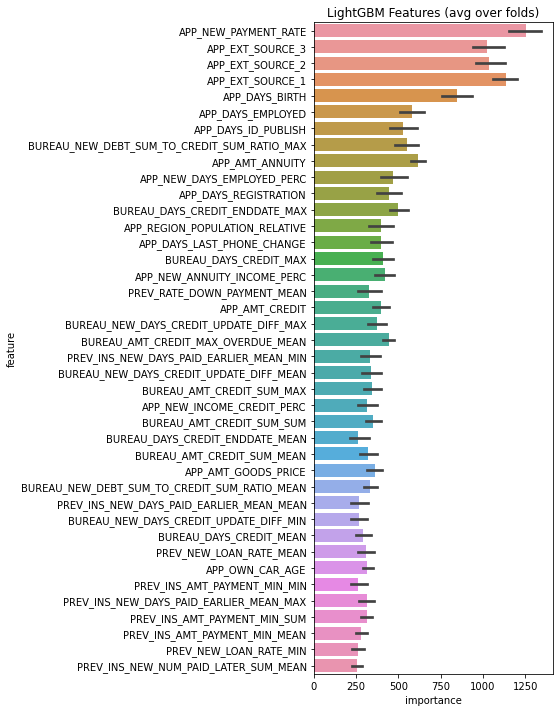

In [13]:
if __name__ == "__main__":
    with timer("Full model run"):
        main()